In [26]:
import pylab as plt
import imageio
import os
import numpy as np
import pandas as pd
import time
import utils
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from torch.autograd import Function
from torch.autograd import Variable

from skimage.transform import resize
import cv2

## Util Functions

path_label_loader 

In [27]:
def path_label_loader(path):
    """
    Args:
     path: Folder path containing subfolders of images
    Output:
     images: List of image path
     labels: Numpy array of labels
    """
    images = []
    labels = []
    
    for s_folder in os.listdir(path):
        label = int(''.join([s for s in s_folder if s.isdigit()]))
        img_folder = os.path.join(path, s_folder)
        
        for img in os.listdir(img_folder):
            if img.endswith(".jpg"):
                image_path = os.path.join(img_folder, img)
                images.append(image_path)
                labels.append(label)
                
    labels = np.array(labels) - 1
    images = np.array(images)
                
    return images, labels

In [28]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir,labels, transform = False):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = labels


    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform != False:
            img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

In [29]:
def create_data_loader(img_path, img_label, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = (128,128)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])
        
    
    dataset = CustomImageDataset(img_path, img_label, transform)

    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    
    return data_loader

In [30]:
def eval_on_test_set(net, test_loader,is_cnn = True, verbose=1):
    
    total_error = 0
    batch_num = 0
    
    for test_data, test_label in test_loader:
        
        bs = test_label.shape[0]
        test_data=test_data.to(device)
        test_label=test_label.to(device)
        
        if is_cnn:
            inputs = test_data
        else:
            inputs = test_data.view(bs, 128*128*3)
        
        scores=net( inputs ) 

        error = utils.get_error( scores , test_label)

        total_error += error.item()
        
        batch_num += 1
        
    total_error = total_error / batch_num
    
    if verbose == 1:
        print( 'error rate on test set =', total_error*100 ,'percent\n')
        
    return total_error

In [37]:
def train_model(net, n_epoch, my_lr, train_loader, test_loader, is_cnn = True, momentum=0.9, verbose=1):
    """
    Train a given model with specified hyperparameters
    
    Args:
     net: NN model to be trained
     n_epoch: Number of epochs to train the model
     bs: Batch size for minibatch GD
     lr: Learning rate of GD
     train_data: Torch tensor of dim [N:rgb:width:height]
     train_label: Torch tensor of dim [N]
     verbose: Print out metrics during training if 1, default 1
    
    Output:
     net: Trained NN model
     records: Dictionary containing metrics history, including training loss/error for each epoch/minibatch, test error for each epoch
    """
    
    N = len(train_loader)
    
    net = net.to(device)
    
    train_loss_hist_mb = []
    train_loss_hist = []
    train_error_hist = []
    test_error_hist = []
    
    start=time.time()

    for epoch in range(1,n_epoch+1):

        if not epoch%10:
            my_lr = my_lr / 1.5

        # optimizer=torch.optim.SGD( net.parameters() , lr=my_lr, momentum=momentum )
        optimizer=torch.optim.Adam(net.parameters(), lr=my_lr)

        running_loss=0
        running_error=0
        num_batches=0
            
        for minibatch_data, minibatch_label in train_loader:


            # FORWARD AND BACKWARD PASS
            bs = minibatch_label.shape[0]

            optimizer.zero_grad()


            minibatch_data=minibatch_data.to(device)                
            minibatch_label=minibatch_label.to(device)

            if is_cnn:
                inputs = minibatch_data
            else:                    
                inputs = minibatch_data.view(bs, 128*128*3)


            inputs.requires_grad_()

            scores=net( inputs ) 

            loss =  criterion( scores , minibatch_label.long()) 

            loss.backward()
            
            optimizer.step()


            # COMPUTE STATS
            running_loss += loss.detach().item()

            error = utils.get_error( scores.detach() , minibatch_label)
            running_error += error.item()

            num_batches+=1   
            train_loss_hist_mb.append(running_error/num_batches)
                
        # AVERAGE STATS THEN DISPLAY
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed = (time.time()-start)/60

        if verbose == 1:
            print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        test_error = eval_on_test_set(net, test_loader,is_cnn = is_cnn, verbose=verbose) 
        
        train_loss_hist.append(total_loss)
        train_error_hist.append(total_error)
        test_error_hist.append(test_error)
    
    records = {'train_loss_mb': train_loss_hist_mb,
              'train_loss': train_loss_hist,
              'train_error': train_error_hist,
              'test_error': test_error_hist}
        
    return records

In [35]:
def save_net(net, path):
    torch.save(net.state_dict(), path)

In [36]:
def load_net(model, path):
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(path))
    model.eval()

## Classification Models

In our project, we attempted 4 different models as follows:
1. First we started with a 3-layer mlp model. 
2. Then we attempted a self-designed basic CNN model with 4 convolutional layers. 
3. Lastly, we attempted two well-known CNN architectures, namely VGG16 and ResNet18.

In addition, in order to make our model work with the CAM visualization in the later part. We did some changes to the fully connected layer in all CNN architecture as follows: 
- A global average pooling was applied to the final CNN layer. (i.e. average pool to 1 x 1)
- All CNN artichectures have exactly one fully connected linear layer. The input size of this linear layer is the number of chanels in the last CNN layer. The output size is the number of prediction classes. 

In [38]:
# use cuda if cuda is found, else use cpu.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, "is running")

cuda is running


### MLP

Our MLP module has three linear layers. \
The input is our flatten image (3 x 128 x 128). The two hidden layers both have hidden size 50. The output size is the number of prediction classes, which is 13.

In [9]:
class mlp(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(mlp , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size1)
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2)
        self.layer3 = nn.Linear(  hidden_size2 , output_size)
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

In [ ]:
my_mlp=mlp(128*128*3, 50, 50, 13)
my_mlp.to(device)
print(my_mlp)

mlp(
  (layer1): Linear(in_features=49152, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=13, bias=True)
)


### Self-designed CNN

Our Self-designed CNN has three conv blocks with the same filter size 3 x 3, padding size 1 and striding size 1 \
Each conv layer is followed by a Batch Normalization, a relu activation and an average pooling (2 x2 for the first two blocks, golabl average pooling for the last block). \
\
Shapes after each block:
- First block: 3 x 128 x 128 -> 32 x 64 x 64 
- Second block: 32 x 64 x 64 -> 64 x 32 x 32
- Third block: 64 x 32 x 32 -> 128 x 1 x 1 
- FC layer: 128 -> 13

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.layer = nn.Sequential(
            # 3x128x128 -> 32x64x64
            nn.Conv2d(3,32,3,1,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            # 32x64x64 -> 64x32x32
            nn.Conv2d(32,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            # 64 -> 128x32x32
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(32,32)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(128,13)
        )       
        
    def forward(self,x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = self.avg_pool(out)
        out = out.view(bz, 128)
        out = self.fc_layer(out) 

        return out

In [18]:
eg_CNN = CNN()
eg_CNN.to(device)
print(eg_CNN)

CNN(
  (layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (avg_pool): Sequential(
    (0): AvgPool2d(kernel_size=32, stride=32, padding=0)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=128, out_features=13, bias=True)
  )
)


### LeNet

In [11]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()
        
        self.layer = nn.Sequential(
            # CL1:   3 * 128 x 128  -->    50 x 128 x 128 
            nn.Conv2d(3,   50,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(50),
            nn.ReLU(),

            # MP1: 50 x 128 x 128 -->    50 x 64 x 64
            nn.MaxPool2d(2,2),

            # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
            nn.Conv2d(50,  100,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(100),
            nn.ReLU(),

            # MP2: 100 x 64 x 64 -->    100 x 32 x 32
            nn.MaxPool2d(2,2)
        )
        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(32,32)
        )
        
        self.fc_layer = nn.Sequential(
            # LL1:   100 x 32 x 32 = 102400 -->  13
            nn.Linear(100, 13),
        )


    def forward(self, x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = self.avg_pool(out)
        out = out.view(bz, 100)
        out = self.fc_layer(out) 
    
        return out

In [26]:
my_lenet = LeNet5_convnet()
my_lenet.to(device)
print(my_lenet)

LeNet5_convnet(
  (layer): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): Sequential(
    (0): AvgPool2d(kernel_size=32, stride=32, padding=0)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=100, out_features=13, bias=True)
  )
)


### VGG16
We built a modified version of VGG16. We have the following changes based on the original VGG16: 
- We add a Batch normalization after each conv layer.
- The global average pooling is applied after last conv layer.
- We only have one fully connected linear layer with input_size = number of chanels in the last conv layers, output_size = number of prediction classes. 

Shapes after each CNN block:
- First Block: 3 x 128 x 128 -> 64 x 64 x 64
- Second Block: 64 x 64 x 64 -> 128 x 32 x 32
- Third Block: 128 x 32 x 32 -> 256 x 1 x 1
- FC layer: 256 -> 13


In [12]:
class VGG16(nn.Module):

    def __init__(self):

        super(VGG16, self).__init__()
        
        self.layer = nn.Sequential(
            # CL1:   3 * 128 x 128  -->    65 x 128 x 128 
            nn.Conv2d(3,   64,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # CL2: 64 x 128 x 128 -->    64 x 128 x 128
            nn.Conv2d(64,   64,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # MP1: 64 x 128 x 128 -->    64 x 64 x 64
            nn.MaxPool2d(2,2),
            
            # CL3: 64 x 64 x 64  -->    128 x 64 x 64 
            nn.Conv2d(64,  128,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # CL4: 128 x 64 x 64  -->    128 x 64 x 64 
            nn.Conv2d(128,  128,  kernel_size=3,  padding=1 ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # MP2: 128 x 64 x 64 -->    128 x 32 x 32
            nn.MaxPool2d(2,2),
            
            # CL5: 128 x 32 x 32  -->    256 x 32 x 32 
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # CL6: 256 x 32 x 32  -->    256 x 32 x 32     
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # MP3: 256 x 32 x 32 -->    256 x 16 x 16
            nn.MaxPool2d(2,2),
            
            # CL7: 256 x 16 x 16  -->    512 x 16 x 16
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # CL8: 512 x 16 x 16  -->    512 x 16 x 16
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            
        )
        
        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(16,16)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(512, 13),
        )



    def forward(self, x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = self.avg_pool(out)
        out = out.view(bz, 512)
        out = self.fc_layer(out) 
    
        return out

In [29]:
my_VGG16 = VGG16()
my_VGG16.to(device)
print(my_VGG16)

VGG16(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

### Resnet

The architecture of ResNet-18 fits well to our requirement for CAM visualization. Hence, we used the original version of ResNet18. \
ResNet18 has 4 resblock. Each ResBlock is contructed by addding skip connections shortcut to the sequentially learning. This is shown in the figure below. \
<img src='./resblock.png'> 


Shapes after each Res Block:
- First Block: 3 x 128 x 128 -> 64 x 128 x 128
- Second Block: 64 x 128 x 128 -> 128 x 64 x 64
- Third Block: 128 x 64 x 64 -> 256 x 32 x 32
- Fourth Block: 256 x 32 x 32 -> 512 x 64 x 64 


In [13]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

    
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=13):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
                    
            # resblock 1
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False),
            
            # resblock 2
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False),
            
            # resblock 3
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False),
            
            # resblock 4
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(512, 13),
        )

    def forward(self, x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = self.avg_pool(out)
        out = out.view(bz, 512)
        out = self.fc_layer(out) 

        return out

In [32]:
my_ResNet18 = ResNet18(3, ResBlock)
my_ResNet18.to(device)
print(my_ResNet18)

ResNet18(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## Load Data

In [20]:
path = "../data/clean_images_index"

images, labels = path_label_loader(path)
print(len(images))
print(len(labels))

2061
2061


In [21]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([156, 152, 156, 170, 150, 129, 178, 141, 185, 159, 152, 161, 172]))

In [22]:
# Use 1648 images as training set and 413 images as test set
train_indice = np.random.choice(2061, 1648, replace=False)
train_path = images[train_indice]
train_label = labels[train_indice]
test_path = images[~train_indice]
test_label = labels[~train_indice]

In [23]:
train_loader = create_data_loader(train_path, train_label, 32)
test_loader = create_data_loader(test_path, test_label, 32)
criterion = nn.CrossEntropyLoss()

## Classification Model Training

In this training section, we trained our four models under the same setting as follows:
- Number of epochs = 30
- Use ADAM as otpimizer
- Learning Rate is initilized at 1e-4
- Learning rate is decayed by 1.5 after every 10 epoches

### Train with MPL

In [19]:
mlp_record = train_model(net = my_mlp, n_epoch = 20, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = False, verbose=1)
save_net(my_mlp, "mlp.pth")

epoch= 1 	 time= 0.1218672792116801 min 	 lr= 0.0001 	 loss= 130.78913795489532 	 error= 91.58653846153845 percent
error rate on test set = 92.60817307692307 percent

epoch= 2 	 time= 0.302167812983195 min 	 lr= 0.0001 	 loss= 2.5638479590415955 	 error= 92.3076923076923 percent
error rate on test set = 90.5048076923077 percent

epoch= 3 	 time= 0.452560301621755 min 	 lr= 0.0001 	 loss= 2.56340505526616 	 error= 91.5264423076923 percent
error rate on test set = 90.32451923076923 percent

epoch= 4 	 time= 0.6365116715431214 min 	 lr= 0.0001 	 loss= 2.5629477225817165 	 error= 91.2860576923077 percent
error rate on test set = 90.38461538461539 percent

epoch= 5 	 time= 0.815853766600291 min 	 lr= 0.0001 	 loss= 2.562707713017097 	 error= 91.22596153846155 percent
error rate on test set = 90.38461538461539 percent

epoch= 6 	 time= 0.9942144433657328 min 	 lr= 0.0001 	 loss= 2.56248978468088 	 error= 91.22596153846155 percent
error rate on test set = 90.38461538461539 percent

epoch= 7 	

### Train with self-designed CNN

In [24]:
cnn_record = train_model(net = eg_CNN, n_epoch = 30, my_lr = 1e-3, train_loader = train_loader, test_loader = test_loader, verbose=1)
save_net(eg_CNN, "simple_cnn.pth")

epoch= 1 	 time= 0.15943409204483033 min 	 lr= 0.001 	 loss= 2.215227397588583 	 error= 70.3125 percent
error rate on test set = 60.09615384615385 percent

epoch= 2 	 time= 0.4395202954610189 min 	 lr= 0.001 	 loss= 1.940197685590157 	 error= 60.09615384615385 percent
error rate on test set = 54.206730769230774 percent

epoch= 3 	 time= 0.7173134406407674 min 	 lr= 0.001 	 loss= 1.789512113882945 	 error= 56.129807692307686 percent
error rate on test set = 51.92307692307693 percent

epoch= 4 	 time= 0.9956607302029927 min 	 lr= 0.001 	 loss= 1.6744362574357252 	 error= 53.90625 percent
error rate on test set = 51.92307692307693 percent

epoch= 5 	 time= 1.2363659381866454 min 	 lr= 0.001 	 loss= 1.5816407318298633 	 error= 49.21875 percent


KeyboardInterrupt: 

### Train with lenet

In [27]:
lenet_record = train_model(net = my_lenet, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = True, verbose=1)
save_net(my_lenet, "lenet.pth")

epoch= 1 	 time= 0.1233900547027588 min 	 lr= 0.0001 	 loss= 2.498557618031135 	 error= 84.43509615384616 percent
error rate on test set = 76.4423076923077 percent

epoch= 2 	 time= 0.32618828217188517 min 	 lr= 0.0001 	 loss= 2.3472481415821957 	 error= 74.93990384615384 percent
error rate on test set = 71.51442307692307 percent

epoch= 3 	 time= 0.602729860941569 min 	 lr= 0.0001 	 loss= 2.2549560895332923 	 error= 70.49278846153845 percent
error rate on test set = 67.54807692307693 percent

epoch= 4 	 time= 0.852323575814565 min 	 lr= 0.0001 	 loss= 2.200035645411565 	 error= 67.12740384615384 percent
error rate on test set = 67.1875 percent

epoch= 5 	 time= 1.1189888000488282 min 	 lr= 0.0001 	 loss= 2.163497411287748 	 error= 65.68509615384616 percent
error rate on test set = 63.942307692307686 percent

epoch= 6 	 time= 1.4203523596127827 min 	 lr= 0.0001 	 loss= 2.126940995454788 	 error= 62.86057692307693 percent
error rate on test set = 62.74038461538461 percent

epoch= 7 	 ti

### Train with VGG-16

In [30]:
VGG_record = train_model(net = my_VGG16, n_epoch = 30, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = True, verbose=1)
save_net(my_VGG16, "vgg16.pth")

epoch= 1 	 time= 0.1868393818537394 min 	 lr= 0.0001 	 loss= 1.8455197765276983 	 error= 60.817307692307686 percent
error rate on test set = 52.76442307692307 percent

epoch= 2 	 time= 0.4715275843938192 min 	 lr= 0.0001 	 loss= 1.5327491576855 	 error= 48.67788461538461 percent
error rate on test set = 39.84375 percent

epoch= 3 	 time= 0.7627179145812988 min 	 lr= 0.0001 	 loss= 1.3589755044533656 	 error= 43.32932692307692 percent
error rate on test set = 36.237980769230774 percent

epoch= 4 	 time= 1.067507803440094 min 	 lr= 0.0001 	 loss= 1.244618302354446 	 error= 38.581730769230774 percent
error rate on test set = 34.43509615384615 percent

epoch= 5 	 time= 1.3730268359184266 min 	 lr= 0.0001 	 loss= 1.1436340453533025 	 error= 35.03605769230769 percent
error rate on test set = 28.90625 percent

epoch= 6 	 time= 1.6838570753733317 min 	 lr= 0.0001 	 loss= 1.0622483732608647 	 error= 31.009615384615387 percent
error rate on test set = 27.103365384615387 percent

epoch= 7 	 time=

### Train with Resnet

In [33]:
my_ResNet18 = train_model(net = my_ResNet18, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = True, verbose=1)

epoch= 1 	 time= 0.2126059095064799 min 	 lr= 0.0001 	 loss= 2.015839872451929 	 error= 68.26923076923077 percent
error rate on test set = 51.92307692307693 percent

epoch= 2 	 time= 0.5211462020874024 min 	 lr= 0.0001 	 loss= 1.1418796731875493 	 error= 33.35336538461539 percent
error rate on test set = 13.521634615384615 percent

epoch= 3 	 time= 0.8026925166447957 min 	 lr= 0.0001 	 loss= 0.3635017301600713 	 error= 8.353365384615383 percent
error rate on test set = 8.834134615384617 percent

epoch= 4 	 time= 1.1518914898236592 min 	 lr= 0.0001 	 loss= 0.16598787531256676 	 error= 3.245192307692308 percent
error rate on test set = 8.954326923076923 percent

epoch= 5 	 time= 1.5069618980089823 min 	 lr= 0.0001 	 loss= 0.10124708404048131 	 error= 1.9831730769230769 percent
error rate on test set = 9.735576923076923 percent

epoch= 6 	 time= 1.859419333934784 min 	 lr= 0.0001 	 loss= 0.09881041657466155 	 error= 2.283653846153846 percent
error rate on test set = 9.615384615384617 perc

## Training Result

|Model|Train Accuracy|Test Accuracy|
|:----------:|:----------:|:----------:|
|MLP|10%|10%|
|Basic_CNN|87%|85%|
|VGG16|96%|97%|
|ResNet18|99%|91%|

# CAM

In [35]:
model = my_VGG16
params = list(model.fc_layer.parameters())
weight = np.squeeze(params[0].cpu().data.numpy())
print('weight.shape', weight.shape)

weight.shape (13, 512)


In [39]:
image, label = next(iter(test_loader))
# image = image[0].reshape(1,3,128,128)
# label = label[0]

model.eval()
scores = model(image.cuda()) # get the raw scores
probs = torch.nn.functional.softmax(scores, dim=1).data.squeeze() # use softmax to generate the probability distribution for the scores
probs, idx = probs.sort(-1, True) # sort the probability distribution in descending order, and idx[0] is the predicted class
print('sum of probabilities: %.0f'%torch.sum(probs.cpu().data).numpy())
print('true class: ', label.cpu().numpy())
print('predicated class: ', idx[:,0].cpu().numpy())

sum of probabilities: 32
true class:  [ 4 11  6 11 12  9 12  2  3  7  6  6  1  9 10  9  4  6  7  2  8  8 11  2
  8  4  9  9  2  2  9  8]
predicated class:  [ 4 11  6 11 12  9 12  2  3  7  6  6  1  9 10  9  4  6  7  2  8  8 11  2
  8  4  9  9  2  2  9  8]


In [40]:
feature_maps = model.layer(image.cuda())
feature_maps.shape

torch.Size([32, 512, 16, 16])

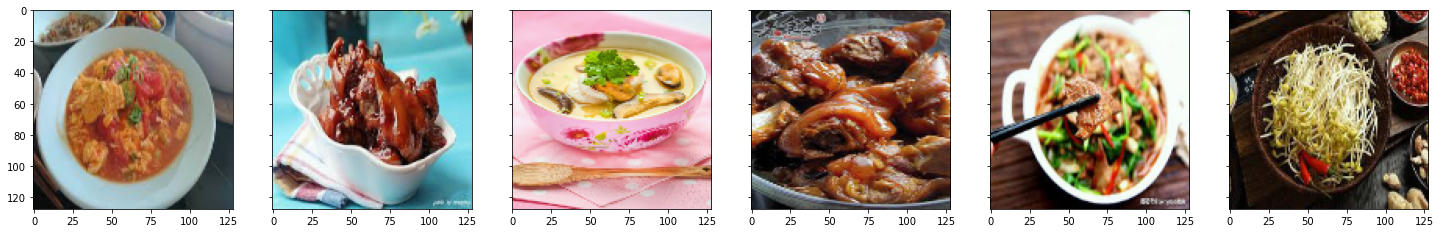

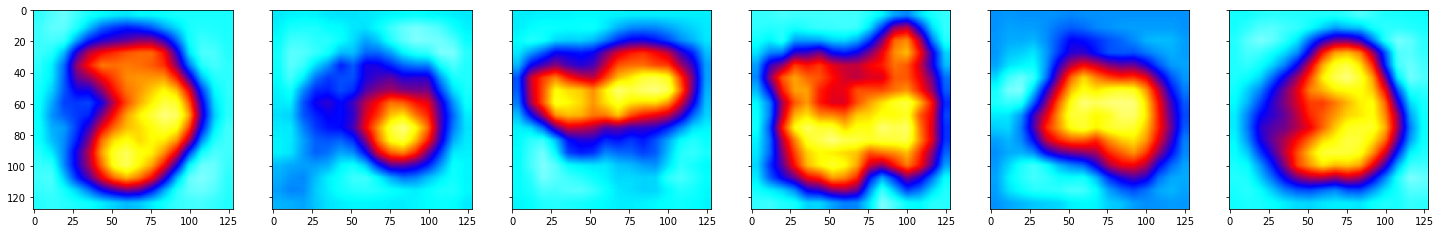

In [41]:
def return_CAM(feature_conv, weight, class_idx):
    """
    return_CAM generates the CAMs and up-sample it to 224x224
    arguments:
    feature_conv: the feature maps of the last convolutional layer
    weight: the weights that have been extracted from the trained parameters
    class_idx: the label of the class which has the highest probability
    """
    size_upsample = (128, 128)
    
    # we only consider one input image at a time, therefore in the case of 
    # VGG16, the shape is (1, 512, 7, 7)
    bz, nc, h, w = feature_conv.shape 
    output_cam = []
    i = 0
    for idx in class_idx:
        # print('idx', idx)
        beforeDot =  feature_conv[i].reshape((nc, h*w)) # -> (512, 16*16)
        cam = np.matmul(weight[idx], beforeDot) # -> (1, 512) x (512,16*16) = (1,16*16)
        cam = cam.reshape(h, w) # -> (16 ,16)
        cam = cam.numpy()
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img) # -> Scale to 0-255 rgb representation 
        output_cam.append(cv2.resize(cam_img, size_upsample)) # -> (128 ,128)
        i += 1
    return output_cam


feature_maps = model.layer(image.cuda()) # get the feature maps of the last convolutional layer
# print('feature_maps.shape: ', feature_maps.cpu().detach().numpy().shape)

CAMs = return_CAM(feature_maps.cpu().detach(), weight, idx.cpu().numpy()[:,0]) # generate the CAM for the input image

fig, axes = plt.subplots(1,6, sharex=True, sharey=True, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    heatmap = cv2.applyColorMap(CAMs[i], cv2.COLORMAP_JET)
    disp_img = image[i]
    disp_img = disp_img.reshape((3, 128, 128)).numpy().transpose((1, 2, 0)) 
    disp_img = disp_img - disp_img.min()
    disp_img = disp_img / disp_img.max()

    ax.imshow(disp_img)


plt.show()

fig, axes = plt.subplots(1,6, sharex=True, sharey=True, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    heatmap = cv2.applyColorMap(CAMs[i], cv2.COLORMAP_JET) 
    heatmap = -heatmap + heatmap.max()
    ax.imshow(heatmap)
      
plt.show()